In [1]:
from sklearn.linear_model import Ridge
from sklearn.tree import ExtraTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np

In [2]:
gpm = pd.read_csv('./datasets/googleplaystore.csv').dropna()
gpm = gpm.loc[gpm['Installs'] != 'Free']

In [3]:
gpm['Installs'].unique()

array(['10,000+', '500,000+', '5,000,000+', '50,000,000+', '100,000+',
       '50,000+', '1,000,000+', '10,000,000+', '5,000+', '100,000,000+',
       '1,000,000,000+', '1,000+', '500,000,000+', '100+', '500+', '10+',
       '5+', '50+', '1+'], dtype=object)

In [4]:
gps_t = pd.DataFrame()
gps_t['Rating'] = gpm['Rating']
gps_t['Reviews'] = gpm['Reviews'].apply(int)
gps_t['Installs'] = gpm['Installs'].map(lambda a: int(a.replace('+', '').replace(',', '')))
stdscaler = MinMaxScaler()
gps_t = pd.DataFrame(stdscaler.fit_transform(gps_t), columns=gps_t.columns)
gps_t.head()

,Rating,Reviews,Installs
0,0.775,0.000002,0.00001
1,0.725,0.000012,0.00050
2,0.925,0.001120,0.00500
3,0.875,0.002759,0.05000
4,0.825,0.000012,0.00010


In [5]:
pf = PolynomialFeatures(5)

In [6]:
d = pd.DataFrame({'Rating': gps_t['Rating'].to_numpy(), 'help': np.ones(gps_t.shape[0])})

In [7]:
x_train, x_test, y_train, y_test = train_test_split(pf.fit_transform(d, gps_t['Installs']), gps_t['Installs'], stratify=gps_t['Installs'])

In [8]:
raiting_checkout_pred = GridSearchCV(
    scoring=mean_squared_error,
    estimator=Ridge(), 
    param_grid={
        'alpha': np.arange(0.00000001, 0.000001, 0.00000001),
    },
    n_jobs=4
).fit(x_train, y_train)

d:\MoreTech5\MoreTech\lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(


In [9]:
raiting_checkout_pred.best_estimator_.alpha

1e-08

In [10]:
r2_score(y_pred=raiting_checkout_pred.predict(x_test), y_true=y_test)

0.009456221296278322

In [11]:
raiting_checkout_pred_tree = GridSearchCV(
    scoring=mean_squared_error,
    estimator=ExtraTreeRegressor(), 
    param_grid={
        'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
        'max_depth': np.arange(2, 8)
    },
    n_jobs=4
).fit(x_train, y_train)

d:\MoreTech5\MoreTech\lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
  warnings.warn(


In [12]:
raiting_checkout_pred_tree.best_estimator_.criterion

'squared_error'

In [13]:
r2_score(y_pred=raiting_checkout_pred_tree.best_estimator_.predict(x_test), y_true=y_test)

0.00266941572407986

(array([6923.,    0.,    0.,    0.,   54.,    0.,    0.,    0.,    0.,
          43.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

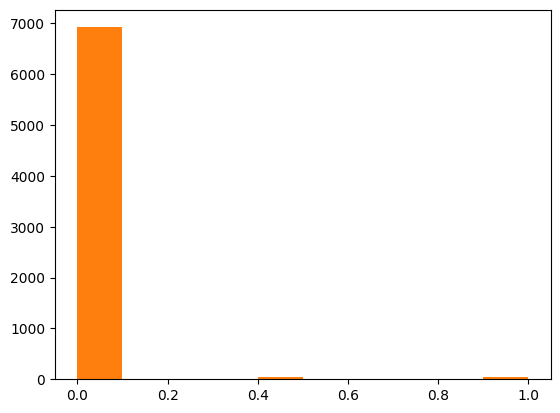

In [14]:
import matplotlib.pyplot as plt
plt.hist(raiting_checkout_pred_tree.best_estimator_.predict(x_train))
plt.hist(y_train)

(array([ 732.,    0.,    0.,    0., 3490.,    0.,    0.,    0.,    0.,
        5138.]),
 array([0.0001523 , 0.00257346, 0.00499461, 0.00741577, 0.00983692,
        0.01225808, 0.01467924, 0.01710039, 0.01952155, 0.0219427 ,
        0.02436386]),
 <BarContainer object of 10 artists>)

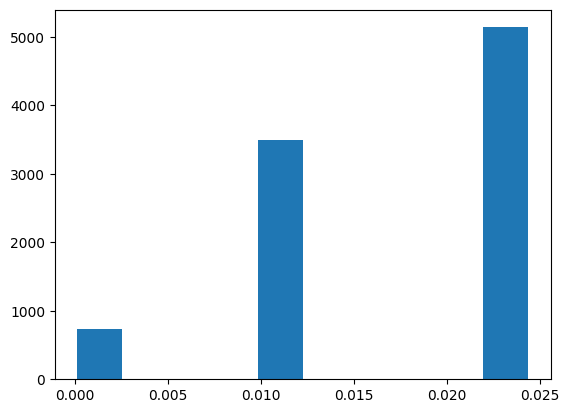

In [15]:
plt.hist(raiting_checkout_pred_tree.best_estimator_.predict(pf.transform(d)))

(array([9230.,    0.,    0.,    0.,   72.,    0.,    0.,    0.,    0.,
          58.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

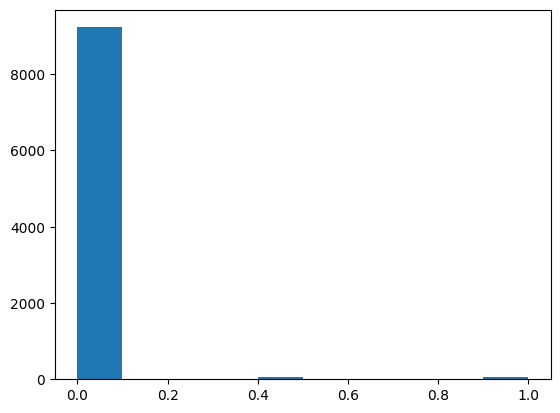

In [16]:
plt.hist(gps_t['Installs'],)

In [17]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(y_pred=raiting_checkout_pred_tree.predict(x_test), y_true=y_test)

46891088466.249275

In [18]:
import pickle
import dill

In [19]:
with open('models/raiting_check/pf.pkl', 'wb') as f:
    dill.dump(pf, f)

In [20]:
with open('models/raiting_check/std_scaler_for_raiting.pkl', 'wb') as f:
    dill.dump(stdscaler, f)

In [21]:
with open('models/raiting_check/raiting_checkout_pred_tree.pkl', 'wb') as f:
    dill.dump(raiting_checkout_pred_tree.best_estimator_, f)

In [22]:
def dataset_preprocessor_for_raiting(raiting: list, pf: PolynomialFeatures, stdscaler = StandardScaler):
    d = pd.DataFrame({'Rating': raiting, 'Reviews': np.ones(len(raiting)), 'Installs': np.ones(len(raiting))})
    d = pd.DataFrame({'Rating': stdscaler.transform(d)[:, 0], 'help': np.ones(len(raiting))})
    return pf.transform(d)

In [23]:
dataset_preprocessor_for_raiting([2], pf, stdscaler)

array([[1.000000e+00, 2.500000e-01, 1.000000e+00, 6.250000e-02,
        2.500000e-01, 1.000000e+00, 1.562500e-02, 6.250000e-02,
        2.500000e-01, 1.000000e+00, 3.906250e-03, 1.562500e-02,
        6.250000e-02, 2.500000e-01, 1.000000e+00, 9.765625e-04,
        3.906250e-03, 1.562500e-02, 6.250000e-02, 2.500000e-01,
        1.000000e+00]])

In [24]:
with open('models/raiting_check/dataset_preprocessor_for_raiting.pkl', 'wb') as f:
    dill.dump(dataset_preprocessor_for_raiting, f)